In [1]:
import random, math
from matplotlib import pyplot as plt
random.seed(2026)

# Score-Based Model
スコアベースモデルとは、スコアを用いたランジュバン・モンテカルロが持つ問題点を解決するための、大きさの異なるノイズを用いた複数のスコア関数を学習する方法である。

## スコアを用いたランジュバン・モンテカルロの問題点

1. **低密度領域における推定スコア関数の不正確性**：被積分関数が$p(x)$に重み付けされているために、$p(x)$の小さい領域が$p(x)$の大きい領域に比べて相対的に無視されることに起因して、推定されるスコア関数が$p(x)$の小さな領域で不正確になる。
$$
\theta^{\text{ESM}} = \argmin_\theta \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left|\left| \hat{s}_\theta(x) - s(x) \right|\right|}^2 \right] = \frac{1}{2} \int_{\mathbb{R}^d} p(x) {\left|\left| \hat{s}_\theta(x) - s(x) \right|\right|}^2 dx
$$
2. **多峰性を持つ確率分布に対する学習の困難性**：MCMCを用いたサンプリングに共通する問題として、サンプルが直前に得られたサンプルに立脚して得られるため、データ分布が多峰性を持つ場合、ある峰から別の峰に移るために多くのステップを要する。例えばランジュバン・モンテカルロでは以下の更新則に従う。
$$
x_{k+1} = x_{k} + \alpha s(x_{k}) + \sqrt{2\alpha}u
$$

### Example 1. ランジュバン・モンテカルロの限界；混合ガウス分布

今、データが混合ガウス分布（Gaussian Mixture Model, GMM）に従うとわかっているとする。
$$
p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x; \mu_k, \sigma_k^2)
$$
よほど恣意的な設定を置かない限り、GMMは多峰性を持つ。
このデータを用いてデノイジングスコアマッチングおよびランジュバン・モンテカルロによるサンプリングを試みる。

今回の例において、デノイジングスコアマッチングにおける学習は「理想的に」終了したとする；
デノイジングスコアマッチングにおける目的関数$L$が
$$
L = \frac{1}{2} \mathbb{E}_{(x, \tilde{x}) \sim p(x)p(\tilde{x}|x)} \left[ {\left|\left| \hat{s}_\theta(\tilde{x}) - s_\sigma(\tilde{x} | x) \right|\right|}^2 \right] = \frac{1}{2} \mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ {\left|\left| \hat{s}_\theta(\tilde{x}) - s_\sigma(\tilde{x}) \right|\right|}^2  \right] + \text{Const.}
$$
と表現されることに注意すれば、理想的に学習が終了した場合、提案分布はノイズ付き分布$p_\sigma(\tilde{x})$に等しくなる。
また、そのノイズ付き分布について考察すると、
$$
\begin{align*}
p_\sigma(\tilde{x})
 &= \int_{-\infty}^{\infty} p(x) \text{Pr}(\epsilon = \tilde{x}-x | \epsilon \sim \mathcal{N}(0, \sigma^2)) dx \\
 &= \int_{-\infty}^{\infty} p(x) \mathcal{N}(\tilde{x}-x; 0, \sigma^2) dx \\
 &= \sum_{k=1}^K \pi_k \int_{-\infty}^{\infty} \mathcal{N}(x; \mu_k, \sigma_k^2) \mathcal{N}(\tilde{x}-x; 0, \sigma^2) dx \\
 &= \sum_{k=1}^K \pi_k \mathcal{N}(\tilde{x}; \mu_k, \sigma^2 + \sigma_k^2)
\end{align*}
$$
より、GMMの形で表現できることがわかる（最後の式変形は正規分布の再生性による）。

提案分布のスコア関数$\hat{s}_\sigma(\tilde{x})$は、
$$
\begin{align*}
\hat{s}_\sigma(\tilde{x})
 &= \nabla_x \ln{p_\sigma(\tilde{x})} = \sum_{k=1}^K r_k \left( -\frac{x - \mu_k}{\sigma^2 + \sigma_k^2} \right)
\end{align*}
$$
と表現される。ただし、式中の$r_k$は負担率（responsibility）：
$$
r_k = \frac{\pi_k \mathcal{N}(\tilde{x}; \mu_k, \sigma^2 + \sigma_k^2)}{\sum_{\kappa=1}^K \pi_k \mathcal{N}(\tilde{x}; \mu_\kappa, \sigma^2 + \sigma_\kappa^2)}
$$
である。
これを用いてランジュバン・モンテカルロを実行することで、データと同種の（厳密にはノイズが乗るが）分布におけるサンプリングが可能となるはずである。

では、ノイズの大きさが小さすぎる場合と、大きすぎる場合で、サンプリング結果がどのようになるかを確認する。

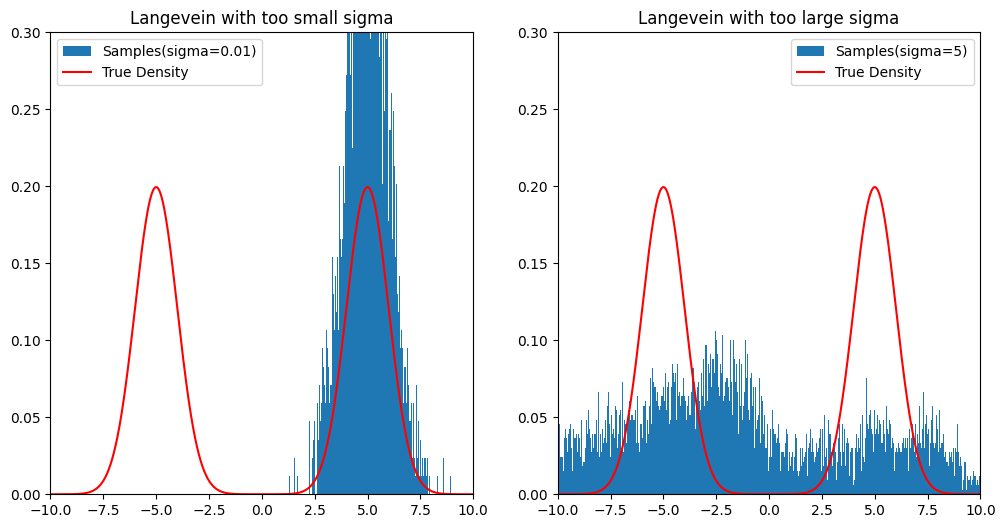

In [2]:
distributions = {
    "mixture_ratio": [0.5, 0.5],
    "means": [-5, 5],
    "variances": [1.0, 1.0]
}

def gaussPdf(x, mu, variance):
    return (1 / math.sqrt(2 * math.pi * variance)) * math.exp(-((x-mu)**2)/(2*variance))

def gmmPdf(x, distributions):
    K = len(distributions["mixture_ratio"])
    return sum([
        distributions["mixture_ratio"][k] * gaussPdf(x, distributions["means"][k], distributions["variances"][k])
        for k in range(K)
    ])

def langeveinMonteCarlo(distributions, sigma, size, init_x, alpha=0.1):
    def scoreFunction(x, distributions, sigma):
        K = len(distributions["mixture_ratio"])
        
        gmmPdfs = [
                distributions["mixture_ratio"][k] * gaussPdf(x, distributions["means"][k], distributions["variances"][k])
                for k in range(K)
            ]
        responsibilities = [pdf / sum(gmmPdfs) for pdf in gmmPdfs]

        return sum([
            responsibilities[k] * (-(x - distributions["means"][k])/(sigma**2 + distributions["variances"][k]**2))
            for k in range(K)
        ])
    
    x = init_x
    burnin = size // 10
    sample = list()
    for i in range(size+burnin):
        u = random.gauss(0, 1)
        x = x + alpha * scoreFunction(x, distributions, sigma) + ((2 * alpha) ** 0.5) * u
        if i >= burnin:
            sample.append(x)
    
    return sample

size = 10000; init_x = 0
# Case 1: too small sigma
sample_1 = langeveinMonteCarlo(distributions, 0.001, size, init_x)
# Case 2: too large sigma
sample_2 = langeveinMonteCarlo(distributions, 5.0, size, init_x)

bins = size // 10
x_limit = [-10, 10]; y_limit = [0, 0.3]
x_range = [x_limit[0] + (x_limit[1]-x_limit[0]) * i / 1000 for i in range(1000)]
truth = [gmmPdf(x, distributions) for x in x_range]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(sample_1, bins=bins, density=True, label="Samples(sigma=0.01)")
axes[0].plot(x_range, truth, color="red", label="True Density")
axes[0].set_xlim(x_limit)
axes[0].set_ylim(y_limit)
axes[0].set_title("Langevein with too small sigma")
axes[0].legend()
axes[1].hist(sample_2, bins=bins, density=True, label="Samples(sigma=5)")
axes[1].plot(x_range, truth, color="red", label="True Density")
axes[1].set_xlim(x_limit)
axes[1].set_ylim(y_limit)
axes[1].set_title("Langevein with too large sigma")
axes[1].legend()

plt.show()

ノイズの大きさが小さすぎる場合、デノイジングスコアマッチングによって推定されたスコアは真の（ノイズのない）分布のスコアに近くなり、MCMCに共通する課題：一つの峰にサンプルが囚われてしまう現象が発生する。
一方で、ノイズの大きさが大きすぎる場合、推定スコアは真のスコアとはかけ離れたもの（ただの単峰ガウス分布）に近くなり、当然サンプルとしてふさわしくない。

## 複数の異なるレベルのノイズによる多峰分布への適応

スコアベースモデルでは、大きさの異なる$T$個のスケール$\sigma_{\text{min}} = \sigma_1 < \sigma_2 < \cdots < \sigma_T = \sigma_{\text{max}}$を用意し、ノイズが付与されたデータの分布$p_{\sigma_t}(\tilde{x})$を考える。

$$
p_{\sigma_t}(\tilde{x}) = \int_{\mathbb{R}^d} p(x) \mathcal{N}(\tilde{x}; x, \sigma_t^2) dx
$$

デノイジングスコアマッチングと同様に、$p_{\sigma_t}(\tilde{x})$からのサンプルは、元データ$x$に対して$\mathcal{N}(0, \sigma_t^2)$からサンプリングされたノイズを付与することで得られる。

$$
\tilde{x} = x + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma_t^2)
$$

$\sigma_t$が非常に大きい場合、$\tilde{x}$中の$x$の影響が無視できるほど小さくなり、$\tilde{x}$は正規分布に従っているとみなせる。
逆に、$\sigma_t$が非常に小さい場合、$\tilde{x}$はほぼ$x$と等しく、元の分布の情報を残していると言える。
よって、まず大きな$\sigma_t$を用いた分布でランジュバン・モンテカルロを実行し、それにより得られた結果を初期値として使って、より小さい$\sigma_t$を用いた分布で再びランジュバン・モンテカルロを実行する。
これにより、元の分布に多峰性があったとしても、それらの峰を網羅することが期待される。
また、$p_{\sigma_t}(\tilde{x})$はノイズが付与された分布であるから、そのスコア関数はデノイジングスコアマッチングによって学習可能である。

まとめると、スコアベースモデルは以下のように実行される。
1. $x$の初期値を定める。
2. 大きさの異なる$T$個のスケール$\sigma_{\text{min}} = \sigma_1 < \sigma_2 < \cdots < \sigma_T = \sigma_{\text{max}}$、および$\alpha_1, \cdots, \alpha_T$を用意する。
3. $\mathcal{N}(0, \sigma_t^2)$からノイズ$\epsilon$をサンプリングし、ノイズ付きデータ$\tilde{x} = x + \epsilon$を生成することを考え、デノイジングスコアマッチングによって条件付き確率$p(\tilde{x}|x)$のスコア関数$s_{\sigma_t}(\tilde{x} | x)$を目標としたデノイジングスコアマッチングを行う。これによって得られたモデルを$s_{\theta}(\tilde{x}, \sigma_t)$とする。
4. $t = 1, \cdots, T$の各ステップにおいて、以下 Step 5,6 を行う。
5. $k = 1, \cdots, K$の各ステップにおいて、以下 Step 6 を行う。
6. $x \leftarrow x + \alpha_t s_\theta(x, \sigma_t) + \sqrt{2\alpha} u_k, \quad u_k \sim \mathcal{N}(0, 1)$
7. 最後の$x$を出力する。

### Example 2. 混合ガウス分布来訪

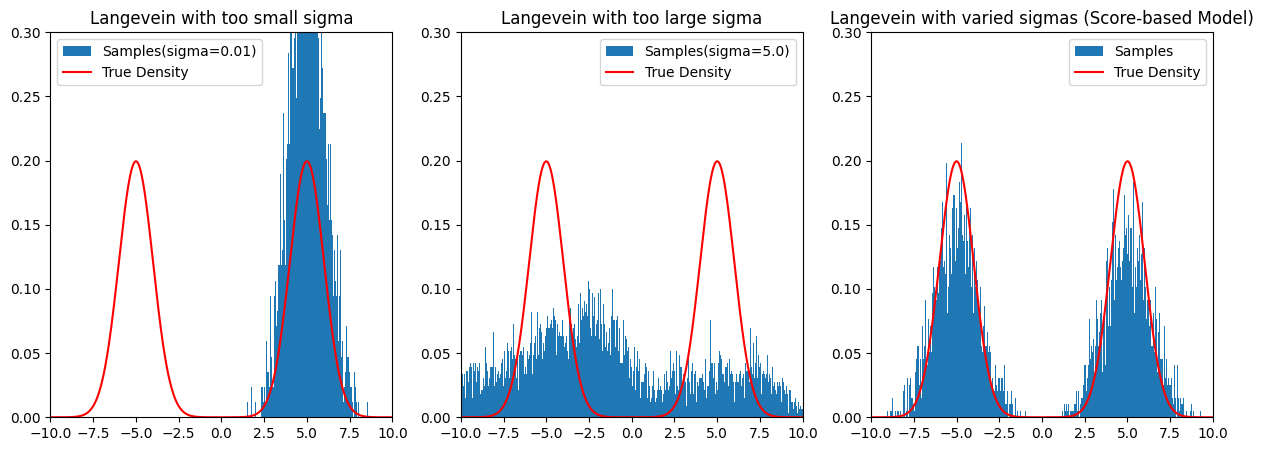

In [3]:
def innerLangeveinMonteCarlo(distributions, sigma, size, init_x, alpha=0.1, last=False):
    def scoreFunction(x, distributions, sigma):
        K = len(distributions["mixture_ratio"])
        
        gmmPdfs = [
                distributions["mixture_ratio"][k] * gaussPdf(x, distributions["means"][k], distributions["variances"][k])
                for k in range(K)
            ]
        responsibilities = [pdf / sum(gmmPdfs) for pdf in gmmPdfs]

        return sum([
            responsibilities[k] * (-(x - distributions["means"][k])/(sigma**2 + distributions["variances"][k]**2))
            for k in range(K)
        ])
    
    x = init_x
    burnin = size // 10
    sample = list()
    for i in range(size+burnin):
        u = random.gauss(0, 1) if not last or i < size+burnin-1 else 0
        x = x + alpha * scoreFunction(x, distributions, sigma) + ((2 * alpha) ** 0.5) * u
        if i >= burnin:
            sample.append(x)
    
    return sample

T = 100; sigmas = [0.001]
for t in range(T-1):
    sigmas.append(sigmas[-1] * 1.07)
reversed(sigmas)

size = 10000
x = init_x; alpha = 0.1
sample_3 = list()
for k in range(size):
    for t in range(T):
        alpha_t = alpha * (sigmas[t] / sigmas[0])
        x = innerLangeveinMonteCarlo(distributions, sigmas[t], size=100, init_x=x, alpha=alpha, last=k==size-1)[-1]
    sample_3.append(x)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(sample_1, bins=bins, density=True, label="Samples(sigma=0.01)")
axes[0].plot(x_range, truth, color="red", label="True Density")
axes[0].set_xlim(x_limit)
axes[0].set_ylim(y_limit)
axes[0].set_title("Langevein with too small sigma")
axes[0].legend()
axes[1].hist(sample_2, bins=bins, density=True, label="Samples(sigma=5.0)")
axes[1].plot(x_range, truth, color="red", label="True Density")
axes[1].set_xlim(x_limit)
axes[1].set_ylim(y_limit)
axes[1].set_title("Langevein with too large sigma")
axes[1].legend()
axes[2].hist(sample_3, bins=bins, density=True, label="Samples")
axes[2].plot(x_range, truth, color="red", label="True Density")
axes[2].set_xlim(x_limit)
axes[2].set_ylim(y_limit)
axes[2].set_title("Langevein with varied sigmas (Score-based Model)")
axes[2].legend()

plt.show()

多峰性のある分布についても適切にサンプリングできていることが確認された。